# Statistical Arbitrage in Cryptocurrency through Liquidation Cascades
by identifying forced selling events and capturing the subsequent mean reversion.

Strategy Overview:
- Detects liquidation events using multi-timeframe price drops and volume spikes
- Identifies cascade liquidation patterns across multiple assets
- Enters long positions during panic selling to capture behavioral finance inefficiencies
- Exits when prices revert to fair value or technical conditions change


Idea: Use Coinglass liquidation data to selectively detect liquidation cascades and act on them, then hold to generate profit as the prices revert. 

In this run, we get binance data from 2023-01-01 to 2024-01-31; other periods starting from 2020 were used to capture the effects of COVID as well

Author: Nitish Kaza

In [1]:
from binance.client import Client as bnb_client
from datetime import datetime
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import time
from scipy import stats


C:\Users\Nitish\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
client = bnb_client(tld='us') 

In [3]:
#Data collection function

st = '2023-01-01'
et = '2024-01-31'

def get_binance_px(symbol, freq, start_ts=st, end_ts=et):
    data = client.get_historical_klines(symbol, freq, start_ts, end_ts)
    df = pd.DataFrame(data, columns=[
        'open_time','open','high','low','close','volume','close_time',
        'quote_volume','num_trades','taker_base_volume','taker_quote_volume','ignore'
    ])
    df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
    df.set_index('open_time', inplace=True)
    df[['close','volume']] = df[['close','volume']].astype(float)
    return df[['close','volume']]

In [4]:
#Assets to be included in the strategy

univ = [
    'BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'SOLUSDT', 'XRPUSDT',
    'ADAUSDT', 'DOGEUSDT', 'AVAXUSDT', 'DOTUSDT', 'MATICUSDT',
    'LTCUSDT', 'SHIBUSDT', 'TRXUSDT', 'LINKUSDT', 'BCHUSDT',
    'UNIUSDT', 'XLMUSDT', 'ATOMUSDT', 'FILUSDT', 'ETCUSDT'
]

freq = '1h'
px, vol = {}, {}

for sym in univ:
    try:
        df = get_binance_px(sym, freq)
        px[sym] = df['close']
        vol[sym] = df['volume']
        time.sleep(1.5)  # avoid API rate limits
    except Exception as e:
        print(f"Failed to load {sym}: {e}")



In [5]:
px = pd.DataFrame(px).sort_index()
vol = pd.DataFrame(vol).sort_index()
px = px.reindex(pd.date_range(px.index[0], px.index[-1], freq=freq))
vol = vol.reindex_like(px)
ret = px.pct_change()

#   LIQUIDATION EVENT DETECTION ALGORITHM
    
    This function identifies forced liquidation events in cryptocurrency markets by analyzing
    price drops, volume spikes, and cascade patterns. The algorithm is designed to capture
    behavioral finance phenomena where panic selling creates temporary price dislocations.
    
    Key Components:
    1. Multi-timeframe price analysis to detect different liquidation patterns
    2. Dynamic volume thresholds using rolling percentiles to adapt to market conditions
    3. Cascade detection to identify multi-stage liquidation events
    4. Market-wide confirmation to filter out single-asset noise
    
    Parameters:
    -----------
    px : pd.DataFrame
        Hourly price data for cryptocurrency assets
    vol : pd.DataFrame  
        Hourly volume data for cryptocurrency assets
    initial_drop : float
        Threshold for initial liquidation signal (default: 5%)
    cascade_drop : float
        Additional drop threshold for cascade detection (default: 3%)
    vol_percentile : int
        Volume percentile threshold for confirmation (default: 95th percentile)
    min_assets : int
        Minimum number of assets that must signal simultaneously (default: 3)
        
    Returns:
    --------
    pd.DataFrame
        Boolean matrix indicating liquidation events for each asset at each timestamp
        
    Strategy Rationale:
    ------------------
    Liquidation events represent forced selling by leveraged traders, creating temporary
    price dislocations below fair value. These events exhibit specific characteristics:
    - Sharp price drops over short timeframes
    - Abnormally high trading volume
    - Contagion effects across correlated assets
    - Predictable mean reversion as panic subsides

In [6]:
def detect_liquidation_events(px, vol, 
                            initial_drop=0.05, cascade_drop=0.03, 
                            vol_percentile=95, min_assets=3):
    """
    Enhanced liquidation detection with cascade patterns
    """
    crash_signals = pd.DataFrame(index=px.index)
    
    for sym in px.columns:
        ret_1h = px[sym].pct_change()
        ret_2h = px[sym].pct_change(periods=2)
        
        vol_thresh_95 = vol[sym].rolling(168).quantile(0.95)  # 7-day 95th percentile
        vol_thresh_90 = vol[sym].rolling(168).quantile(0.90)  # 7-day 90th percentile
        
        strong_drop = ret_1h < -initial_drop  # 5% drop in 1h
        cascade = (ret_2h < -(initial_drop + cascade_drop)) & (ret_1h > -cascade_drop)  # cascade pattern
        extreme_drop = ret_1h < -(initial_drop * 1.6)  
        
        extreme_vol = vol[sym] > vol_thresh_95
        high_vol = vol[sym] > vol_thresh_90
        
        liquidation_signal = ((strong_drop | extreme_drop) & extreme_vol) | (cascade & high_vol)
        
        crash_signals[sym] = liquidation_signal
    
    joint_crashes = crash_signals.sum(axis=1) >= min_assets
    return crash_signals.where(joint_crashes, False)

Now we identify crashes based on the above function and check if bounce occurs afterward to generate a signal. 

In [7]:
crashes = detect_liquidation_events(px, vol)

In [8]:
confirmed_bounce = px.pct_change().shift(-1) > 0
signals = crashes & confirmed_bounce
signals = signals.shift(1)

# Returns from trading strategy implementing an adaptive hold period approach based on short-term momentum signals:

Signal Detection: Identifies trading opportunities when signals are active for specific assets at given timestamps

Adaptive Hold Period:
If 1-hour forward return > 2%, hold for 1 hour to capture quick gains
Otherwise, hold for 2 hours to allow for longer-term momentum
Transaction Costs: Applies 0.2% transaction cost per trade to account for realistic trading friction

Return Calculation:
1-Hour Returns: px.pct_change().shift(-1) - forward-looking 1-hour price changes
2-Hour Returns: px.pct_change(2).shift(-2) - forward-looking 2-hour price changes
Net Returns: Gross returns minus transaction costs for performance evaluation

Data Collection:
The strategy tracks both aggregate performance (strategy_returns) and detailed trade-level information (trade_details) including timestamps, assets, returns, and hold periods for comprehensive analysis.



In [9]:
strategy_returns = []
trade_details = []
transaction_cost = 0.002

ret_1h = px.pct_change().shift(-1)
ret_2h = px.pct_change(2).shift(-2)

for timestamp in signals.index:
    if pd.isna(timestamp):
        continue
        
    active_signals = signals.loc[timestamp]
    if active_signals.any():
        signal_assets = active_signals[active_signals].index.tolist()
        
        for asset in signal_assets:
            if timestamp not in ret_1h.index or timestamp not in ret_2h.index:
                continue
                
            return_1h = ret_1h.loc[timestamp, asset]
            return_2h = ret_2h.loc[timestamp, asset]
            
            if pd.isna(return_1h) or pd.isna(return_2h):
                continue
            
            if return_1h > 0.02:
                gross_return = return_1h
                hold_period = 1
            else:
                gross_return = return_2h
                hold_period = 2
            
            net_return = gross_return - transaction_cost
            
            strategy_returns.append(net_return)
            trade_details.append({
                'timestamp': timestamp,
                'asset': asset,
                'gross_return': gross_return,
                'net_return': net_return,
                'hold_period': hold_period
            })

In [10]:
strategy_returns = pd.Series(strategy_returns)
num_trades = len(strategy_returns)

print(f"Total trades: {num_trades}")
print(f"Sample strategy returns: {strategy_returns.head(10).values}")
print(f"Max single period return: {strategy_returns.max()}")
print(f"Min single period return: {strategy_returns.min()}")
print(f"Mean return per period: {strategy_returns.mean()}")

Total trades: 98
Sample strategy returns: [ 0.01583591  0.00871081  0.00843219  0.00830098 -0.0004345   0.00225747
  0.00951631  0.01250589  0.00598935  0.00979392]
Max single period return: 0.1911563799168532
Min single period return: -0.027178068577107806
Mean return per period: 0.005174487949764721


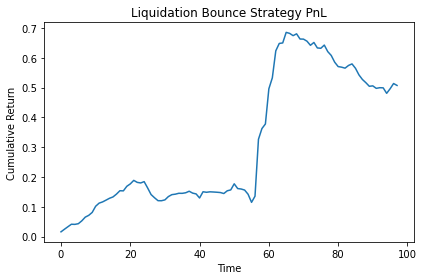

In [11]:
strategy_returns.cumsum().plot(title="Liquidation Bounce Strategy PnL")
plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.tight_layout()
plt.show()

In [12]:
if len(strategy_returns) > 0:
    # Time frame
    start_date = px.index[0]
    end_date = px.index[-1]
    total_days = (end_date - start_date).days
    n_years = total_days / 365.25 if total_days > 0 else 1

    print(f"Data period: {start_date} to {end_date}")
    print(f"Total days: {total_days}")
    print(f"Years: {n_years:.2f}")

    # Return stats
    total_return = strategy_returns.sum()
    mean_return = strategy_returns.mean()
    std_return = strategy_returns.std()
    trades_per_year = len(strategy_returns) / n_years

    # Annualized return and volatility (linear)
    annualized_return = mean_return * trades_per_year
    annualized_vol = std_return * np.sqrt(trades_per_year)
    
    # Sharpe ratio
    sharpe_ratio = (mean_return / std_return) * np.sqrt(trades_per_year) if std_return > 0 else 0

    # Max drawdown
    cumulative_returns = strategy_returns.cumsum()
    running_max = cumulative_returns.cummax()
    drawdown = cumulative_returns - running_max
    max_drawdown = drawdown.min()

    # Alpha/Beta vs BTC
    btc_returns = ret['BTCUSDT'].dropna()
    strat_ts = pd.Series(0.0, index=px.index)

    for trade in trade_details:
        ts = trade['timestamp']
        if ts in strat_ts.index:
            strat_ts.loc[ts] += trade['net_return']

    aligned = pd.concat([strat_ts, btc_returns], axis=1).dropna()
    if len(aligned) > 50:
        beta, alpha, r_val, _, _ = stats.linregress(aligned.iloc[:,1], aligned.iloc[:,0])
        alpha_annualized = alpha * trades_per_year
        r_squared = r_val**2
    else:
        beta, alpha_annualized, r_squared = 0, 0, 0

    # Output
    print("\n" + "="*60)
    print("PERFORMANCE METRICS")
    print("="*60)
    print(f"Total Return (sum of trades): {total_return:.2%}")
    print(f"Mean Return per Trade: {mean_return:.4%}")
    print(f"Annualized Return: {annualized_return:.2%}")
    print(f"Annualized Volatility: {annualized_vol:.2%}")
    print(f"Sharpe Ratio (Annualized): {sharpe_ratio:.3f}")
    print(f"Max Drawdown: {max_drawdown:.2%}")
    print(f"Alpha (Annualized): {alpha_annualized:.4f}")
    print(f"Beta vs BTC: {beta:.3f}")
    print(f"R-squared: {r_squared:.3f}")
    print(f"Number of Trades: {len(strategy_returns)}")


Data period: 2023-01-01 00:00:00 to 2024-01-31 00:00:00
Total days: 395
Years: 1.08

PERFORMANCE METRICS
Total Return (sum of trades): 50.71%
Mean Return per Trade: 0.5174%
Annualized Return: 46.89%
Annualized Volatility: 25.96%
Sharpe Ratio (Annualized): 1.806
Max Drawdown: -20.45%
Alpha (Annualized): 0.0049
Beta vs BTC: -0.010
R-squared: 0.000
Number of Trades: 98
